In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as opt
import csv
from arc import *
import matplotlib
import pandas as pd
matplotlib.rcParams['figure.dpi'] = 50

## Optimize time-optimal single pulse gates

In [2]:
#Set phase guess and pulse time for Pupillo gate
# pulse_time= 7.63*1 # in Omega*t dimension-less units
cs = Cesium()
n=50
pulse_time= 7.65
resolution = 100 # number of phase steps in the pulse
# PhaseGuess = [(-1.2*np.sin(2*np.pi*x/pulse_time)-0.5) for x in np.linspace(0,pulse_time,resolution)] #input a phase profile guess 
PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
Omega_Rabi=2*np.pi*1.1 #2.785 #MHz
Blockade = 2*np.pi*7.5  #MHz
R_lifetime = cs.getStateLifetime(n=n,l=1,j=3/2,temperature=300, includeLevelsUpTo=70,s=0.5)*1e6
print(R_lifetime)

98.99837930254411


In [3]:
# #Set phase guess and pulse time for Pupillo gate  Harvard parameters
# # pulse_time= 7.63*1 # in Omega*t dimension-less units
# pulse_time= 7.63407
# resolution = 100 # number of phase steps in the pulse
# Omega_Rabi=2*np.pi* 1.06 #MHz
# PhaseGuess = [(0.704973*np.cos((2*np.pi*x)/pulse_time)+0.7318) for x in np.linspace(0,pulse_time,resolution)] #input a phase profile guess 
# Blockade = 2*np.pi*2.6  #MHz
# R_lifetime = 170 # microseconds

In [4]:
# #Set phase guess and pulse time for Pupillo gate  Harvard parameters
# # pulse_time= 7.63*1 # in Omega*t dimension-less units
# pulse_time= 7.63407
# resolution = 100 # number of phase steps in the pulse
# Omega_Rabi=2*np.pi*1.06 #1.06 #MHz
# PhaseGuess = [(0.704973*np.cos((2*np.pi*1.0431*x)/pulse_time)+0.7318) for x in np.linspace(0,pulse_time,resolution)] #input a phase profile guess 
# # PhaseGuess = [(0.704973*np.cos((2*np.pi*1.0431*x)/pulse_time)) for x in np.linspace(0,pulse_time,resolution)] #input a phase profile guess 
# Blockade = 2*np.pi*4 #MHz
# R_lifetime = 170 # microseconds

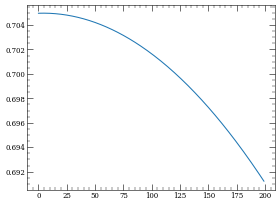

In [29]:
# print(PhaseGuess)
# print(np.linspace(0,pulse_time,resolution))
# for x in np.linspace(0,pulse_time,resolution):
#     print(x)
times = np.load('time.npy')
phases = np.load('phases.npy')
plt.plot(phases)

101


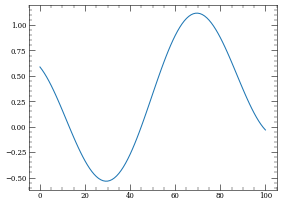

In [24]:
times = [0.,        0.03844221,0.07688442,0.11532663,0.15376884,0.19221106
,0.23065327,0.26909548,0.30753769,0.3459799,0.38442211,0.42286432
,0.46130653,0.49974874,0.53819095,0.57663317,0.61507538,0.65351759
,0.6919598,0.73040201,0.76884422,0.80728643,0.84572864,0.88417085
,0.92261307,0.96105528,0.99949749,1.0379397,1.07638191,1.11482412
,1.15326633,1.19170854,1.23015075,1.26859296,1.30703518,1.34547739
,1.3839196,1.42236181,1.46080402,1.49924623,1.53768844,1.57613065
,1.61457286,1.65301508,1.69145729,1.7298995,1.76834171,1.80678392
,1.84522613,1.88366834,1.92211055,1.96055276,1.99899497,2.03743719
,2.0758794,2.11432161,2.15276382,2.19120603,2.22964824,2.26809045
,2.30653266,2.34497487,2.38341709,2.4218593,2.46030151,2.49874372
,2.53718593,2.57562814,2.61407035,2.65251256,2.69095477,2.72939698
,2.7678392,2.80628141,2.84472362,2.88316583,2.92160804,2.96005025
,2.99849246,3.03693467,3.07537688,3.1138191,3.15226131,3.19070352
,3.22914573,3.26758794,3.30603015,3.34447236,3.38291457,3.42135678
,3.45979899,3.49824121,3.53668342,3.57512563,3.61356784,3.65201005
,3.69045226,3.72889447,3.76733668,3.80577889,3.84422111,3.88266332
,3.92110553,3.95954774,3.99798995,4.03643216,4.07487437,4.11331658
,4.15175879,4.19020101,4.22864322,4.26708543,4.30552764,4.34396985
,4.38241206,4.42085427,4.45929648,4.49773869,4.5361809,4.57462312
,4.61306533,4.65150754,4.68994975,4.72839196,4.76683417,4.80527638
,4.84371859,4.8821608,4.92060302,4.95904523,4.99748744,5.03592965
,5.07437186,5.11281407,5.15125628,5.18969849,5.2281407,5.26658291
,5.30502513,5.34346734,5.38190955,5.42035176,5.45879397,5.49723618
,5.53567839,5.5741206,5.61256281,5.65100503,5.68944724,5.72788945
,5.76633166,5.80477387,5.84321608,5.88165829,5.9201005,5.95854271
,5.99698492,6.03542714,6.07386935,6.11231156,6.15075377,6.18919598
,6.22763819,6.2660804,6.30452261,6.34296482,6.38140704,6.41984925
,6.45829146,6.49673367,6.53517588,6.57361809,6.6120603,6.65050251
,6.68894472,6.72738693,6.76582915,6.80427136,6.84271357,6.88115578
,6.91959799,6.9580402,6.99648241,7.03492462,7.07336683,7.11180905
,7.15025126,7.18869347,7.22713568,7.26557789,7.3040201,7.34246231
,7.38090452,7.41934673,7.45778894,7.49623116,7.53467337,7.57311558
,7.61155779,7.65      ] 

phase = [0.70496697,0.70496966,0.70497163,0.70497286,0.70497338,0.70497316
,0.70497222,0.70497055,0.70496815,0.70496503,0.70496117,0.70495659
,0.70495129,0.70494525,0.70493849,0.704931,0.70492279,0.70491385
,0.70490418,0.70489378,0.70488265,0.7048708,0.70485822,0.70484492
,0.70483088,0.70481612,0.70480063,0.70478442,0.70476748,0.70474981
,0.70473141,0.70471229,0.70469244,0.70467186,0.70465055,0.70462852
,0.70460577,0.70458228,0.70455807,0.70453313,0.70450746,0.70448107
,0.70445395,0.7044261,0.70439753,0.70436823,0.7043382,0.70430745
,0.70427597,0.70424376,0.70421083,0.70417717,0.70414279,0.70410767
,0.70407183,0.70403527,0.70399798,0.70395996,0.70392122,0.70388175
,0.70384155,0.70380063,0.70375898,0.7037166,0.7036735,0.70362967
,0.70358512,0.70353984,0.70349384,0.70344711,0.70339965,0.70335147
,0.70330256,0.70325293,0.70320257,0.70315149,0.70309968,0.70304714
,0.70299388,0.7029399,0.70288519,0.70282975,0.70277359,0.7027167
,0.70265909,0.70260076,0.7025417,0.70248191,0.7024214,0.70236017
,0.70229821,0.70223552,0.70217211,0.70210798,0.70204312,0.70197754
,0.70191124,0.70184421,0.70177645,0.70170797,0.70163877,0.70156884
,0.7014982,0.70142682,0.70135472,0.7012819,0.70120836,0.70113409
,0.7010591,0.70098339,0.70090695,0.70082979,0.7007519,0.7006733
,0.70059397,0.70051392,0.70043314,0.70035164,0.70026942,0.70018648
,0.70010282,0.70001843,0.69993332,0.69984749,0.69976093,0.69967366
,0.69958566,0.69949694,0.6994075,0.69931734,0.69922645,0.69913485
,0.69904252,0.69894947,0.69885571,0.69876122,0.698666,0.69857007
,0.69847342,0.69837605,0.69827795,0.69817914,0.69807961,0.69797935
,0.69787838,0.69777668,0.69767427,0.69757114,0.69746728,0.69736271
,0.69725742,0.6971514,0.69704467,0.69693722,0.69682905,0.69672016
,0.69661056,0.69650023,0.69638919,0.69627742,0.69616494,0.69605174
,0.69593782,0.69582319,0.69570783,0.69559176,0.69547497,0.69535747
,0.69523924,0.6951203,0.69500064,0.69488027,0.69475918,0.69463737
,0.69451484,0.6943916,0.69426764,0.69414297,0.69401758,0.69389147
,0.69376465,0.69363711,0.69350885,0.69337988,0.6932502,0.6931198
,0.69298868,0.69285685,0.69272431,0.69259105,0.69245707,0.69232239
,0.69218698,0.69205087,0.69191403,0.69177649,0.69163823,0.69149926
,0.69135957,0.69121917]

print(len(phases))
plt.plot(phases)

In [6]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_opt(phases):
    

    times=np.linspace(0,pulse_time*1,resolution+1) # Time in dimensionless units omega_rabi*t
    A = phases[0]
    w = phases[1]
    phi = phases[2]
    gamma = phases[3]
    phases = A*np.cos(w*times-phi)+gamma*times
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency
    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2  
    return 1-F_bell

In [7]:
#optimize the fidelity over the input phases using built-in scipy optimizer
phases_out=opt.minimize(fun=pulse_gate_infidelity_opt,x0=PhaseGuess)

In [8]:
#check the optimized fidelity
1-pulse_gate_infidelity_opt(phases_out['x'])

np.float64(0.995459645385605)

In [9]:
1-pulse_gate_infidelity_opt(PhaseGuess)

np.float64(0.9802772995283405)

In [13]:
phases_out['x']

array([ 0.71228826,  1.0858492 , -0.60055236,  0.07674339])

0.7122882597506719 1.0858492043401156 -0.600552363085593 0.07674338653877244


Text(0.5, 0, 'Time $t\\Omega_0$')

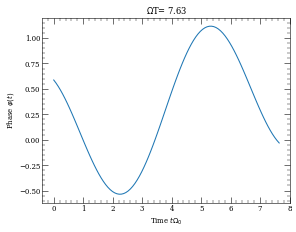

In [10]:
times_list = []
interpolation = []
phases = []
phases =phases_out['x']
A = phases[0]
w = phases[1]
phi = phases[2]
gamma = phases[3]

times = np.linspace(0, pulse_time,resolution + 1)
phases = A*np.cos(w*times-phi)+gamma*times
# for i in range(resolution):
    # times_list.append(np.linspace(0, 7.63,resolution + 1)[i])
    # phases.append(phases_out['x'][i]/2)
# fig, ax = plt.plot(figsize = (8,8))
print(A,w,phi,gamma)
plt.plot(times, phases)


plt.title("$\\Omega$T= 7.63")
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")


In [12]:
result = {'time':times, 'phases':phases}

df = pd.DataFrame(result)
df.to_csv('phases.csv', index=False)
# with open('gate_phase_file.csv','w',newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(row_list)

In [26]:
# times_list = []
# times_list1 = []

# interpolation = []
# phases = []
# for i in range(resolution-1):
#     times_list.append(np.linspace(0,7.63,resolution + 1)[i])
#     phases.append((phases_out['x'][i]-phases_out['x'][i+1]/(7.63/100))*Omega_Rabi/(2*np.pi))
# # fig, ax = plt.plot(figsize = (8,8))

# plt.plot(times_list, phases)
# plt.ylabel("Detuning $\\Delta(t)$")
# plt.xlabel("Time $t\Omega_0$")

In [27]:
# times_list = []
# interpolation = []
# phases = []
# for i in range(resolution):
#     times_list.append(np.linspace(0,7.63,resolution + 1)[i])
#     phases.append(phases_out['x'][i])
# # fig, ax = plt.plot(figsize = (8,8))

# plt.plot(times_list, phases, linewidth=3)
# plt.ylabel("Phase $\\varphi(t)$")
# plt.xlabel("Time $t\Omega_0$")
# plt.tight_layout()
# plt.savefig("Phase profile.pdf", format="pdf")

In [28]:
pulse_time_in_ns=4*int(1e3*pulse_time/Omega_Rabi/4)
pulse_times_in_ns = range(0,pulse_time_in_ns,4)
len(pulse_times_in_ns)

pulse_time_in_ns=4*int(1e3*pulse_time/Omega_Rabi/4)
pulse_times_in_ns = range(0,pulse_time_in_ns,4)
phases_in_radians=np.interp(np.linspace(0,pulse_time,len(pulse_times_in_ns)),np.linspace(0,pulse_time,resolution),phases_out['x']/2)

row_list=  [('time_in_ns', 'phase_in_radians')] + list(list(zip(pulse_times_in_ns,phases_in_radians)))

with open('gate_phase_file.csv','w',newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

In [14]:
sss

NameError: name 'sss' is not defined

In [ ]:
# #Set phase guess and pulse time for Pupillo gate
# pulse_time= 7.63*1 # in Omega*t dimension-less units
# # pulse_time= 14.32 
# resolution = 100 # number of phase steps in the pulse
# PhaseGuess = [(-1*np.cos(4*np.pi*x/pulse_time+0.7))+(-0.4*np.cos(8*np.pi*x/pulse_time-2.5+0.7))-0.5 for x in np.linspace(0,pulse_time,resolution)] #input a phase profile guess 
# Omega_Rabi=2*np.pi* 4.035 #2.785 #MHz
# Blockade = 2*np.pi*140  #MHz
# R_lifetime = 170 # microseconds

# times_list = []
# interpolation = []
# phases = []
# for i in range(resolution):
#     times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
#     phases.append(PhaseGuess[i])
# # fig, ax = plt.plot(figsize = (8,8))

# plt.plot(times_list, phases)
# plt.title("$\\Omega$T= {}".format(pulse_time))
# plt.ylabel("Phase $\\varphi(t)$")
# plt.xlabel("Time $t\Omega_0$")

In [ ]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_opt_amp(phases):
    
    
    times=np.linspace(0,pulse_time*1,resolution+1) # Time in dimensionless units omega_rabi*t
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = None#Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency
    dOmega=0.01
    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 
    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = (OmegaNorm+dOmega)*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bellP = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
     
    return (1-F_bell)+abs(F_bellP-F_bell)*(1/0.01)

In [ ]:
phases_out=opt.minimize(fun=pulse_gate_infidelity_opt_amp,x0=PhaseGuess)

In [ ]:
1-pulse_gate_infidelity_opt(phases_out['x'])

In [ ]:
times_list = []
interpolation = []
phases = []
for i in range(resolution):
    times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
    phases.append(PhaseGuess[i])
# fig, ax = plt.plot(figsize = (8,8))

plt.plot(times_list, phases)
plt.title("$\\Omega$T= {}".format(pulse_time))
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")

In [ ]:
times_list = []
interpolation = []
phases = []
for i in range(resolution):
    times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
    phases.append(phases_out['x'][i])
# fig, ax = plt.plot(figsize = (8,8))

plt.plot(times_list, phases)
plt.title("$\\Omega$T= {}".format(pulse_time))
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")

In [ ]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_blockade_sensitivity(phases, blockade):
    
    
    times=np.linspace(0,pulse_time,resolution+1) # Time in dimensionless units omega_rabi*t
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = blockade/Omega_Rabi # normalize the blockade with the Rabi frequency

    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2  
    return 1-F_bell

In [ ]:
# fidelity_vs_blockade = []
# blockade_list = np.linspace(2*2*np.pi,3.6*2*np.pi,50)
# blockade_list_MHz = np.linspace(2,3.6,50)
# for blockade in blockade_list:
#     fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
#     fidelity_vs_blockade.append(fidelity)

In [ ]:
fidelity_vs_blockade = []
blockade_list = np.linspace(2*2*np.pi,3.6*2*np.pi,50)
blockade_list_MHz = np.linspace(5,7,50)
for blockade in blockade_list:
    fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
    fidelity_vs_blockade.append(fidelity)

In [ ]:
# fidelity_vs_blockade = []
# blockade_list = np.linspace(1.78*2*np.pi,3.2*2*np.pi,13)
# blockade_list_MHz = np.linspace(1.8,3,13)
# for blockade in blockade_list:
#     fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
#     fidelity_vs_blockade.append(fidelity)
    

In [ ]:


matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(15, 10))
plt.ylabel("Fidelity")
plt.xlabel("Blockade (MHz)/(2pi)")
display(plt.plot(blockade_list_MHz, fidelity_vs_blockade))

In [ ]:
1-pulse_gate_infidelity_blockade_sensitivity(phases=phases_out['x'],blockade= 2*np.pi*2.3)

In [ ]:
# #Interpolate and check at high resolution 
# resolution_high = 300

# high_res_phases=np.interp(np.linspace(0,7.63,resolution_high),np.linspace(0,7.63,resolution),phases_out['x'])

In [ ]:
# # Calculates both Bell state fidelity for input phases and return the output for optimization at high resolution
# def pulse_gate_infidelity_opt_high_res(phases):

    
#     times=np.linspace(0,pulse_time,resolution_high+1)
#     OmegaNorm=1 # normalize to 1 to keep timings consistant
#     DecayRate=(1/R_lifetime)/(Omega_Rabi) # normalize with Rabi frequency 
#     B = Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency

#     psi01 = np.array([1,0], complex)
#     psi11 = np.array([1,0,0], complex)
#     if B is None:
#         psi11 = np.array([1,0], complex)
        
#     for i in range(resolution_high):
#         dt = times[i+1]-times[i]
#         Omega = OmegaNorm*np.exp(1j*phases[i])
#         H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]])
#         if B is None:
#             H11 = np.sqrt(2)*H01
#         else:
#             H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])
#             H11[2,2] = B-1j*DecayRate
#         H01[1,1] = -1j*DecayRate/2
#         H11[1,1] = -1j*DecayRate/2
#         psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01
#         psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11
    
#     # Apply single qubit gates
#     phase = psi01[0]/np.abs(psi01[0])
#     psi01/=phase
#     psi11/=phase**2
    
#     #print(psi01)
#     #print(psi11)
    
#     F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2
#     return 1-F_bell

In [ ]:
# #Optimize at high resolution (takes a while)
# phases_out_high_res=opt.minimize(fun=pulse_gate_infidelity_opt_high_res,x0=high_res_phases)

In [ ]:
#optimized fidelity
# 1-pulse_gate_infidelity_opt_high_res(phases_out_high_res['x'])

In [ ]:
# #interpolated fidelity
# 1-pulse_gate_infidelity_opt_high_res(high_res_phases)

In [ ]:
# #Plot the two pulses on top of each other
# times_list = []
# interpolation = []
# phases = []
# for i in range(resolution_high):
#     times_list.append(np.linspace(0,7.63,resolution_high + 1)[i])
#     times_list.append(np.linspace(0,7.63,resolution_high + 1)[i+1])
#     for _ in range(2):
#         interpolation.append(high_res_phases[i])
#         phases.append(phases_out_high_res['x'][i])
# # fig, ax = plt.plot(figsize = (8,8))
# plt.plot(times_list, interpolation)

# plt.plot(times_list, phases)
# plt.ylabel("Phase $\\varphi(t)$")
# plt.xlabel("Time $t\Omega_0$")